<a href="https://colab.research.google.com/github/entc-17-fyp-20/WPF_Data_Visualization/blob/Kusal/Dilated_CNN_forecasted_power.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dilated CNN model**



*   Prepare time series data for training a Convolutional Neural Network (CNN) forecasting model
*   Implement a CNN model in keras to predict the next step ahead (time t+1) in the time series


*   Enable early stopping to reduce the likelihood of model overfitting
*   Evaluate the model on a test dataset

In here we are using dilated CNN model with 3 convolutional layers.

# **SETUP**

In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from glob import glob
from IPython.display import Image
%matplotlib inline
import plotly.express as px
import io


pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

url1 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/S6%2010%20seconed%20data.csv' #S6 10 seconed data.csv
url2 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/AE59_1.csv' #AE59_1
url3 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/AE59_2.csv' #AE59_2
url4 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V08%20June%2010%20sec%20data.csv' #V08 June 10 sec data.csv; does not contain current columns
url5 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V13%20June%2010%20sec%20data.csv' #V13 June 10 sec data.csv
url6 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V08%20July%2010%20sec%20data.csv' #V08 July 10 sec data.csv
url7 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V13%20July%2010%20sec%20data.csv' #V13 July 10 sec data.csv
url8 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/Mannar.csv'  #Mannar dataset-10_min-wind_speed.csv
url9 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/Mannar%20full%20data.csv' #Mannar full data set.csv
df = pd.read_csv(url9)

In [2]:
df=pd.DataFrame(df)
df

,Date & Time,Average Wind Speed (m/s),Average Wind Dirction (deg),Average Active Power (MW),Forecasted Power (kW)
0,8/1/2021 0:00,10.66,186.92,95.84,100.25
1,8/1/2021 0:10,10.71,188.15,96.03,100.01
2,8/1/2021 0:20,10.53,188.78,93.72,97.12
3,8/1/2021 0:30,10.20,189.80,88.84,96.96
4,8/1/2021 0:40,10.34,193.00,90.97,94.08
...,...,...,...,...,...
4404,8/31/2021 23:20,11.62,195.08,100.45,101.74
4405,8/31/2021 23:30,11.16,196.36,98.01,101.78
4406,8/31/2021 23:40,10.66,198.02,93.11,101.85
4407,8/31/2021 23:50,10.90,196.96,93.68,101.29


In [3]:
'''df['Date & Time'][0]="8/1/2021 0:00"
df['Date & Time'][4408]="9/1/2021  0:00"
df'''


'df[\'Date & Time\'][0]="8/1/2021 0:00"\ndf[\'Date & Time\'][4408]="9/1/2021  0:00"\ndf'

In [4]:
df=df.set_index('Date & Time')
df

,Average Wind Speed (m/s),Average Wind Dirction (deg),Average Active Power (MW),Forecasted Power (kW)
Date & Time,,,,
8/1/2021 0:00,10.66,186.92,95.84,100.25
8/1/2021 0:10,10.71,188.15,96.03,100.01
8/1/2021 0:20,10.53,188.78,93.72,97.12
8/1/2021 0:30,10.20,189.80,88.84,96.96
8/1/2021 0:40,10.34,193.00,90.97,94.08
...,...,...,...,...
8/31/2021 23:20,11.62,195.08,100.45,101.74
8/31/2021 23:30,11.16,196.36,98.01,101.78
8/31/2021 23:40,10.66,198.02,93.11,101.85


In [5]:
df.describe()

,Average Wind Speed (m/s),Average Wind Dirction (deg),Average Active Power (MW),Forecasted Power (kW)
count,"4,409.00","4,409.00","4,409.00","4,409.00"
mean,9.95,197.37,72.60,72.22
std,2.59,14.21,31.06,29.21
min,1.81,130.84,-0.76,1.83
25%,8.22,189.00,48.45,45.45
50%,10.06,194.74,84.46,79.70
75%,11.88,203.61,100.99,100.57
max,16.45,311.14,103.42,103.39


**Data set plot**

In [6]:
fig = px.line(df,x=df.index, y=' Average Active Power (MW) ') 
fig.show()

# **Train, validation and test sets**
We separate our dataset into train, validation and test sets.

*   We train the model on the train set.
*   The validation set is used to evaluate the model after each training epoch and ensure that the model is not overfitting the training data.
*   After the model has finished training, we evaluate the model on the test set.

We will allocate last 5% of the data set as test data and 5% before test data as validation data.All the other data will be training data.





In [7]:
L=len(df)
valid_start=int(18*L/20)
test_start=int(19*L/20)

train,valid,test=df[:valid_start],df[valid_start:test_start],df[test_start:L]  #seperate train and test data arrays
print(train.shape)
print(valid.shape)
print(test.shape)

print(train.describe())
print(valid.describe())
print(test.describe())

(3968, 4)
(220, 4)
(221, 4)
       Average  Wind Speed (m/s)  ...   Forecasted Power (kW) 
count                   3,968.00  ...                 3,968.00
mean                        9.88  ...                    70.69
std                         2.65  ...                    29.82
min                         1.81  ...                     1.83
25%                         8.07  ...                    43.72
50%                        10.00  ...                    76.94
75%                        11.88  ...                   100.31
max                        15.88  ...                   103.39

[8 rows x 4 columns]
       Average  Wind Speed (m/s)  ...   Forecasted Power (kW) 
count                     220.00  ...                   220.00
mean                       11.35  ...                    93.61
std                         1.90  ...                    15.18
min                         6.47  ...                    42.51
25%                        10.64  ...                    95.51
50%  

In [8]:
train

,Average Wind Speed (m/s),Average Wind Dirction (deg),Average Active Power (MW),Forecasted Power (kW)
Date & Time,,,,
8/1/2021 0:00,10.66,186.92,95.84,100.25
8/1/2021 0:10,10.71,188.15,96.03,100.01
8/1/2021 0:20,10.53,188.78,93.72,97.12
8/1/2021 0:30,10.20,189.80,88.84,96.96
8/1/2021 0:40,10.34,193.00,90.97,94.08
...,...,...,...,...
8/28/2021 21:50,14.26,216.75,102.77,102.92
8/28/2021 22:00,14.00,217.18,102.55,102.92
8/28/2021 22:10,13.36,219.63,102.22,102.94


In [9]:
#date_time = pd.to_datetime(df_new['Date & Time'], format='%m/%d/%Y %H:%M')

# **Data preparation - training data**

I will get the input for each sample is a vector of previous **T lagged values**

**HORIZON=1** specifies that we have a forecasting horizon of 1 (t+1)

In [10]:
T = 10
HORIZON = 1

**Scale the time series within [0,1]**

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train=pd.DataFrame(train[' Average Active Power (MW) '])
train[' Average Active Power (MW) '] = scaler.fit_transform(train)
train.head(10)

,Average Active Power (MW)
Date & Time,
8/1/2021 0:00,0.93
8/1/2021 0:10,0.93
8/1/2021 0:20,0.91
8/1/2021 0:30,0.86
8/1/2021 0:40,0.88
8/1/2021 0:50,0.90
8/1/2021 1:00,0.91
8/1/2021 1:10,0.94
8/1/2021 1:20,0.94



**Original vs scaled data:**

In [12]:
'''df[df.index < valid_start+1][["Average Wind Speed (m/s)"]].rename(columns={"Average Wind Speed (m/s)":'original wind speed'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={"Average Wind Speed (m/s)":'scaled wind speed'}).plot.hist(bins=100, fontsize=12)
plt.show()'''

'df[df.index < valid_start+1][["Average Wind Speed (m/s)"]].rename(columns={"Average Wind Speed (m/s)":\'original wind speed\'}).plot.hist(bins=100, fontsize=12)\ntrain.rename(columns={"Average Wind Speed (m/s)":\'scaled wind speed\'}).plot.hist(bins=100, fontsize=12)\nplt.show()'

**Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example**

In [13]:
train_shifted = train.copy()
for i in range (1,HORIZON+1):
  train_shifted['y_t+'+str(i)] = train_shifted[' Average Active Power (MW) '].shift(-i)
train_shifted.head(10)

,Average Active Power (MW),y_t+1
Date & Time,,
8/1/2021 0:00,0.93,0.93
8/1/2021 0:10,0.93,0.91
8/1/2021 0:20,0.91,0.86
8/1/2021 0:30,0.86,0.88
8/1/2021 0:40,0.88,0.90
8/1/2021 0:50,0.90,0.91
8/1/2021 1:00,0.91,0.94
8/1/2021 1:10,0.94,0.94
8/1/2021 1:20,0.94,0.92


**Get T no of lagged values**

In [14]:
for t in range(1, T+1):
    train_shifted['active_power_t-'+str(T-t)] = train_shifted[' Average Active Power (MW) '].shift(T-t)
train_shifted = train_shifted.rename(columns={' Average Active Power (MW) ':'Original_active_power'})
train_shifted.head(10)

,Original_active_power,y_t+1,active_power_t-9,active_power_t-8,active_power_t-7,active_power_t-6,active_power_t-5,active_power_t-4,active_power_t-3,active_power_t-2,active_power_t-1,active_power_t-0
Date & Time,,,,,,,,,,,,
8/1/2021 0:00,0.93,0.93,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.93
8/1/2021 0:10,0.93,0.91,nan,nan,nan,nan,nan,nan,nan,nan,0.93,0.93
8/1/2021 0:20,0.91,0.86,nan,nan,nan,nan,nan,nan,nan,0.93,0.93,0.91
8/1/2021 0:30,0.86,0.88,nan,nan,nan,nan,nan,nan,0.93,0.93,0.91,0.86
8/1/2021 0:40,0.88,0.90,nan,nan,nan,nan,nan,0.93,0.93,0.91,0.86,0.88
8/1/2021 0:50,0.90,0.91,nan,nan,nan,nan,0.93,0.93,0.91,0.86,0.88,0.90
8/1/2021 1:00,0.91,0.94,nan,nan,nan,0.93,0.93,0.91,0.86,0.88,0.90,0.91
8/1/2021 1:10,0.94,0.94,nan,nan,0.93,0.93,0.91,0.86,0.88,0.90,0.91,0.94
8/1/2021 1:20,0.94,0.92,nan,0.93,0.93,0.91,0.86,0.88,0.90,0.91,0.94,0.94


In [15]:
train_shifted = train_shifted.dropna(how='any')
train_shifted.head(5)

,Original_active_power,y_t+1,active_power_t-9,active_power_t-8,active_power_t-7,active_power_t-6,active_power_t-5,active_power_t-4,active_power_t-3,active_power_t-2,active_power_t-1,active_power_t-0
Date & Time,,,,,,,,,,,,
8/1/2021 1:30,0.92,0.93,0.93,0.93,0.91,0.86,0.88,0.90,0.91,0.94,0.94,0.92
8/1/2021 1:40,0.93,0.94,0.93,0.91,0.86,0.88,0.90,0.91,0.94,0.94,0.92,0.93
8/1/2021 1:50,0.94,0.95,0.91,0.86,0.88,0.90,0.91,0.94,0.94,0.92,0.93,0.94
8/1/2021 2:00,0.95,0.97,0.86,0.88,0.90,0.91,0.94,0.94,0.92,0.93,0.94,0.95
8/1/2021 2:10,0.97,0.97,0.88,0.90,0.91,0.94,0.94,0.92,0.93,0.94,0.95,0.97


**Convert the target variable into a numpy array(vector format)**

In [16]:
y_train = np.array(train_shifted[["y_t+1"]])

In [17]:
y_train.shape

(3958, 1)

In [18]:
y_train

array([[0.93],
       [0.94],
       [0.95],
       ...,
       [0.99],
       [0.99],
       [0.98]])

**Convert the inputs into a numpy array with shape (samples, time steps, features)**

In [19]:
X_train=np.array(train_shifted[['active_power_t-'+str(T-t) for t in range(1, T+1)]])
X_train = X_train[... , np.newaxis]


In [20]:
X_train.shape

(3958, 10, 1)

In [21]:
X_train[1]

array([[0.93],
       [0.91],
       [0.86],
       [0.88],
       [0.9 ],
       [0.91],
       [0.94],
       [0.94],
       [0.92],
       [0.93]])

# **Data preparation - validation set**

In [22]:
valid=pd.DataFrame(valid[' Average Active Power (MW) '])
valid

,Average Active Power (MW)
Date & Time,
8/28/2021 22:40,101.58
8/28/2021 22:50,101.70
8/28/2021 23:00,101.59
8/28/2021 23:10,101.45
8/28/2021 23:20,101.33
...,...
8/30/2021 10:30,49.74
8/30/2021 10:40,49.20
8/30/2021 10:50,45.19


In [23]:
valid_new=df[valid_start-T+1:test_start]
valid_new=pd.DataFrame(valid_new[' Average Active Power (MW) '])
valid_new.head(20)

,Average Active Power (MW)
Date & Time,
8/28/2021 21:10,102.70
8/28/2021 21:20,102.82
8/28/2021 21:30,102.84
8/28/2021 21:40,102.99
8/28/2021 21:50,102.77
8/28/2021 22:00,102.55
8/28/2021 22:10,102.22
8/28/2021 22:20,101.85
8/28/2021 22:30,101.72


In [24]:
valid_new[' Average Active Power (MW) ']=scaler.transform(valid_new)
valid_new.head()

,Average Active Power (MW)
Date & Time,
8/28/2021 21:10,0.99
8/28/2021 21:20,1.00
8/28/2021 21:30,1.00
8/28/2021 21:40,1.00
8/28/2021 21:50,0.99


In [25]:
valid_shifted = valid_new.copy()
valid_shifted['y_t+1'] = valid_shifted[' Average Active Power (MW) '].shift(-HORIZON)
valid_shifted.head(10)

for t in range(1, T+1):
    valid_shifted['active_power_t-'+str(T-t)] = valid_shifted[' Average Active Power (MW) '].shift(T-t)
vali_shifted = valid_shifted.rename(columns={' Average Active Power (MW) ':'Original_active_power'})

valid_shifted = valid_shifted.dropna(how='any')
y_valid = np.array(valid_shifted[["y_t+1"]])
X_valid=np.array(valid_shifted[['active_power_t-'+str(T-t) for t in range(1, T+1)]])
X_valid = X_valid[... , np.newaxis]

In [26]:
y_valid.shape

(219, 1)

In [27]:
X_valid.shape

(219, 10, 1)

# **Implement the Convolutional Neural Network**
We implement the convolutional neural network with 3 layers, 5 neurons in each layer, a kernel size of 3 in each layer, and dilation rates of 1, 2 and 4 for each successive layer.

In [28]:
from keras.models import Model, Sequential
from keras.layers import Conv1D, Dense, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [29]:
LATENT_DIM = 10
KERNEL_SIZE = 2
BATCH_SIZE = 32
EPOCHS = 30

In [30]:
model = Sequential()
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=1, input_shape=(T, 1)))
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=2))
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=4))
#model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=8))
model.add(Flatten())
model.add(Dense(HORIZON, activation='linear'))

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 10)            30        
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 10)            210       
                                                                 
 conv1d_2 (Conv1D)           (None, 10, 10)            210       
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 551
Trainable params: 551
Non-trainable params: 0
_________________________________________________________________


Use Adam optimizer and mean squared error as the loss function.

In [32]:
model.compile(optimizer='Adam', loss='mse')

In [33]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [34]:
best_val = ModelCheckpoint('model_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [35]:
history = model.fit(X_train,
          y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(X_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

Epoch 1/30
124/124 [==============================] - 3s 10ms/step - loss: 0.1391 - val_loss: 0.0088
Epoch 2/30
124/124 [==============================] - 1s 7ms/step - loss: 0.0102 - val_loss: 0.0059
Epoch 3/30
124/124 [==============================] - 1s 6ms/step - loss: 0.0064 - val_loss: 0.0038
Epoch 4/30
124/124 [==============================] - 1s 7ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 5/30
124/124 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 6/30
124/124 [==============================] - 1s 5ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 7/30
124/124 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 8/30
124/124 [==============================] - 1s 6ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 9/30
124/124 [==============================] - 1s 6ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 10/30
124/124 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 0.001

Load the model with the smallest mape

In [36]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights("model_{:02d}.h5".format(best_epoch))

plot training and validation losses

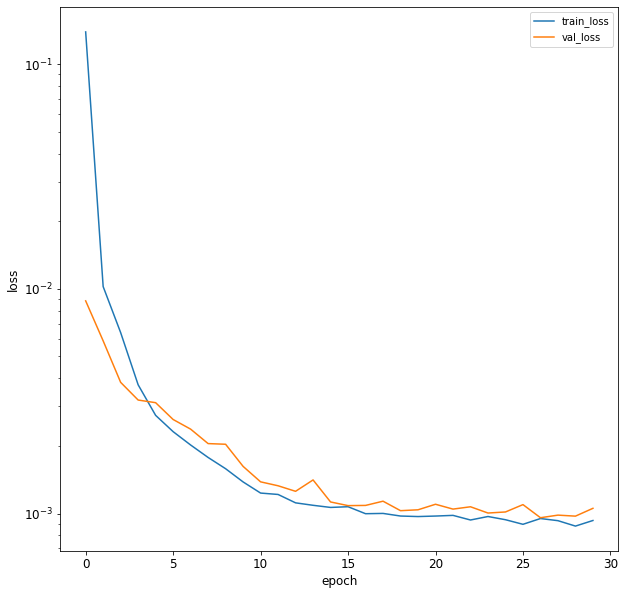

In [37]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

# **Evaluate the model** 

**Create the test set**

In [38]:
test_forecasted=pd.DataFrame(test[' Forecasted Power (kW) '])
test=pd.DataFrame(test[' Average Active Power (MW) '])
print(test_forecasted)
test

                  Forecasted Power (kW) 
Date & Time                             
8/30/2021 11:20                    56.01
8/30/2021 11:30                    57.30
8/30/2021 11:40                    61.88
8/30/2021 11:50                    63.02
8/30/2021 12:00                    63.60
...                                  ...
8/31/2021 23:20                   101.74
8/31/2021 23:30                   101.78
8/31/2021 23:40                   101.85
8/31/2021 23:50                   101.29
1/9/2021                          101.37

[221 rows x 1 columns]


,Average Active Power (MW)
Date & Time,
8/30/2021 11:20,55.50
8/30/2021 11:30,56.08
8/30/2021 11:40,57.41
8/30/2021 11:50,57.97
8/30/2021 12:00,55.53
...,...
8/31/2021 23:20,100.45
8/31/2021 23:30,98.01
8/31/2021 23:40,93.11


In [39]:
test_new=df[test_start-T+1:L]
test_new=pd.DataFrame(test_new[' Average Active Power (MW) '])
test_new.head(20)

,Average Active Power (MW)
Date & Time,
8/30/2021 9:50,39.61
8/30/2021 10:00,40.60
8/30/2021 10:10,47.53
8/30/2021 10:20,53.43
8/30/2021 10:30,49.74
8/30/2021 10:40,49.20
8/30/2021 10:50,45.19
8/30/2021 11:00,48.32
8/30/2021 11:10,47.46


**Scale tht test data**

In [40]:
test_new[' Average Active Power (MW) ']=scaler.transform(test_new)
test_new.head()

,Average Active Power (MW)
Date & Time,
8/30/2021 9:50,0.39
8/30/2021 10:00,0.40
8/30/2021 10:10,0.46
8/30/2021 10:20,0.52
8/30/2021 10:30,0.49


**Create test set features**

In [41]:
test_shifted = test_new.copy()
test_shifted['y_t+1'] = test_shifted[' Average Active Power (MW) '].shift(-HORIZON)
print(test_shifted)

for t in range(1, T+1):
    test_shifted['active_power_t-'+str(T-t)] = test_shifted[' Average Active Power (MW) '].shift(T-t)
test_shifted = test_shifted.rename(columns={' Average Active Power (MW) ':'Original_active_power'})

test_shifted = test_shifted.dropna(how='any')
y_test = np.array(test_shifted[['Original_active_power']])
X_test=np.array(test_shifted[['active_power_t-'+str(T-t) for t in range(1, T+1)]])
X_test = X_test[... , np.newaxis]

                  Average Active Power (MW)   y_t+1
Date & Time                                        
8/30/2021 9:50                          0.39   0.40
8/30/2021 10:00                         0.40   0.46
8/30/2021 10:10                         0.46   0.52
8/30/2021 10:20                         0.52   0.49
8/30/2021 10:30                         0.49   0.48
...                                      ...    ...
8/31/2021 23:20                         0.97   0.95
8/31/2021 23:30                         0.95   0.90
8/31/2021 23:40                         0.90   0.91
8/31/2021 23:50                         0.91   0.91
1/9/2021                                0.91    nan

[230 rows x 2 columns]


**Make predictions on test set**

In [42]:
predictions = model.predict(X_test)
#predictions

In [43]:
predictions=pd.DataFrame(predictions)
predictions

,0
0,0.59
1,0.55
2,0.57
3,0.57
4,0.55
...,...
215,0.98
216,0.97
217,0.94
218,0.88


In [44]:
forecasted_values=np.array(test_forecasted[' Forecasted Power (kW) '])
forecasted_values=pd.DataFrame(forecasted_values)
forecasted_values

,0
0,56.01
1,57.30
2,61.88
3,63.02
4,63.60
...,...
216,101.74
217,101.78
218,101.85
219,101.29


**Compare predictions to actual wind speed**

In [45]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df['prediction'] =predictions 
eval_df['forecasted_values']=forecasted_values
eval_df
#eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
#eval_df

,timestamp,h,prediction,actual,forecasted_values
0,8/30/2021 11:20,t+1,0.59,0.54,56.01
1,8/30/2021 11:30,t+1,0.55,0.55,57.30
2,8/30/2021 11:40,t+1,0.57,0.56,61.88
3,8/30/2021 11:50,t+1,0.57,0.56,63.02
4,8/30/2021 12:00,t+1,0.55,0.54,63.60
...,...,...,...,...,...
215,8/31/2021 23:10,t+1,0.98,0.98,101.67
216,8/31/2021 23:20,t+1,0.97,0.97,101.74
217,8/31/2021 23:30,t+1,0.94,0.95,101.78
218,8/31/2021 23:40,t+1,0.88,0.90,101.85


In [46]:
eval_df[['prediction']]=scaler.inverse_transform(np.array(eval_df[['prediction']]))
eval_df[['actual']]=scaler.inverse_transform(np.array(eval_df[['actual']]))
eval_df[['Our_prediction_diff']]=np.abs(eval_df['prediction']-eval_df['actual'])
eval_df[['CEB_prediction_diff']]=np.abs(eval_df['forecasted_values']-eval_df['actual'])
eval_df['our_rs_eror']=np.sqrt(np.abs(eval_df['prediction']-eval_df['actual']))
eval_df['rs_error']=np.sqrt(np.abs(eval_df['forecasted_values']-eval_df['actual']))
#eval_df[['prediction']].shape
eval_df

,timestamp,h,prediction,actual,forecasted_values,Our_prediction_diff,CEB_prediction_diff,our_rs_eror,rs_error
0,8/30/2021 11:20,t+1,60.98,55.50,56.01,5.48,0.51,2.34,0.71
1,8/30/2021 11:30,t+1,56.78,56.08,57.30,0.70,1.22,0.83,1.10
2,8/30/2021 11:40,t+1,58.80,57.41,61.88,1.39,4.47,1.18,2.11
3,8/30/2021 11:50,t+1,58.25,57.97,63.02,0.28,5.05,0.53,2.25
4,8/30/2021 12:00,t+1,56.03,55.53,63.60,0.50,8.07,0.71,2.84
...,...,...,...,...,...,...,...,...,...
215,8/31/2021 23:10,t+1,101.20,101.18,101.67,0.02,0.49,0.15,0.70
216,8/31/2021 23:20,t+1,100.10,100.45,101.74,0.35,1.29,0.59,1.14
217,8/31/2021 23:30,t+1,96.85,98.01,101.78,1.16,3.77,1.08,1.94
218,8/31/2021 23:40,t+1,90.89,93.11,101.85,2.22,8.74,1.49,2.96


MAPE of our prediction

In [47]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

actual = eval_df['actual']
pred = eval_df['prediction']

mape(actual, pred)

2.1582909631701646

RMSE of our prediction

In [48]:
def rmse(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    x=np.mean((actual - pred)**2)
    return np.sqrt(x)

actual = eval_df['actual']
pred = eval_df['prediction']

rmse(actual, pred)

2.033268847978252

MAPE of CEB preictions

In [49]:
def mape(actual, forecasted): 
    actual, pred = np.array(actual), np.array(forecasted)
    return np.mean(np.abs((actual - forecasted) / actual)) * 100

actual = eval_df['actual']
forecasted = eval_df['forecasted_values']

mape(actual, forecasted)

10.918870806377468

RMSE of CEB preictions

In [50]:
def rmse(actual, forecasted): 
    actual, pred = np.array(actual), np.array(forecasted)
    x=np.mean((actual - forecasted)**2)
    return np.sqrt(x)

actual = eval_df['actual']
forecasted = eval_df['forecasted_values']

rmse(actual, forecasted)

9.03929359166764

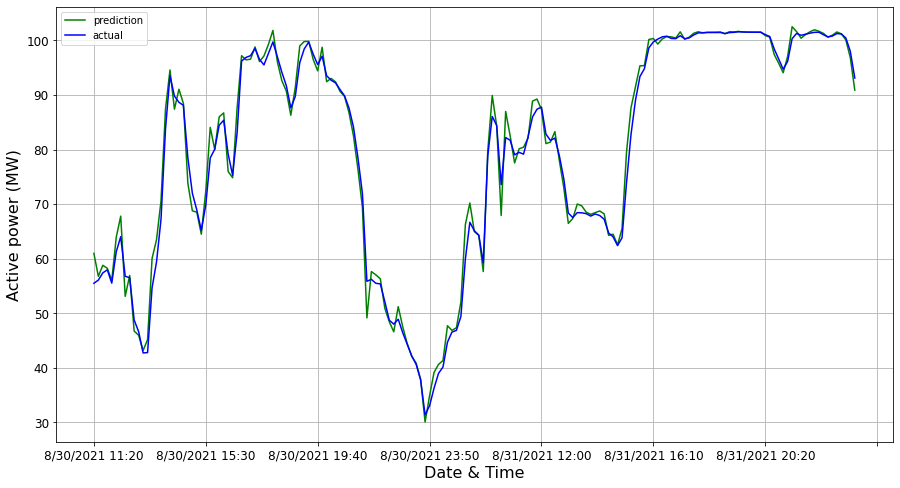

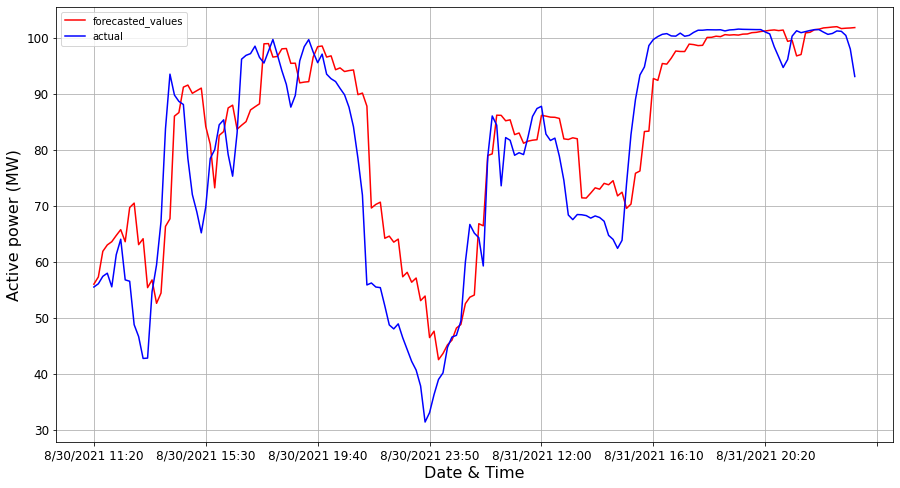

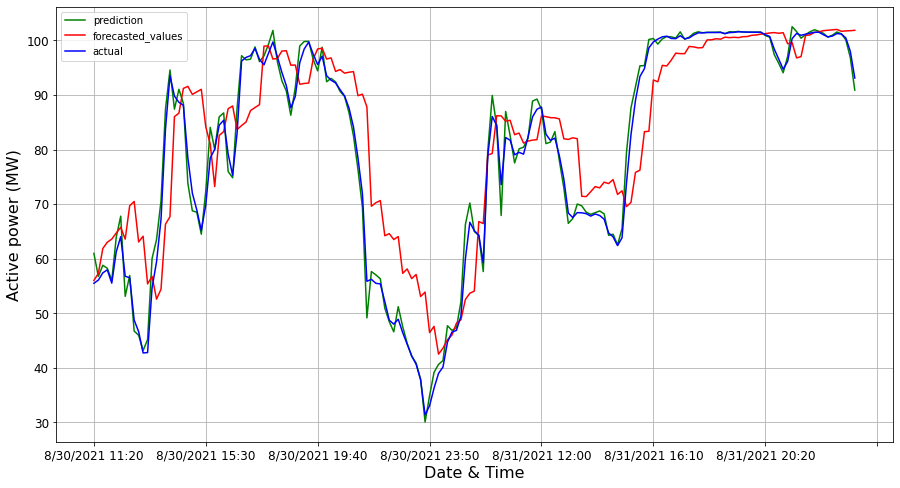

In [51]:
eval_df[eval_df.timestamp<'8/31/2021 23:50'].plot(x='timestamp', y=['prediction','actual'], style=['g','b'],fontsize=12, figsize=(15, 8))
plt.xlabel('Date & Time', fontsize=16)
plt.ylabel('Active power (MW)', fontsize=16)
plt.grid()
plt.show()

eval_df[eval_df.timestamp<'8/31/2021 23:50'].plot(x='timestamp', y=['forecasted_values', 'actual'], style=['r', 'b'],fontsize=12, figsize=(15, 8))
plt.xlabel('Date & Time', fontsize=16)
plt.ylabel('Active power (MW)', fontsize=16)
plt.grid()
plt.show()

eval_df[eval_df.timestamp<'8/31/2021 23:50'].plot(x='timestamp', y=['prediction','forecasted_values', 'actual'], style=['g','r', 'b'],fontsize=12, figsize=(15, 8))
plt.xlabel('Date & Time', fontsize=16)
plt.ylabel('Active power (MW)', fontsize=16)
plt.grid()
plt.show()



**Clean up model files**

In [52]:
for m in glob('model_*.h5'):
    os.remove(m)